In [ ]:
import cv2
import keras
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

import struct

batchSize = 100
datasetCount = 6000
currentImage = 0

imagePath = "Dataset\image_2\\"
labelPath = "Dataset\label_2\\"

In [ ]:
onlyfiles = [f for f in listdir(labelPath) if isfile(join(labelPath, f))]
breakcount = 0
for file in onlyfiles:
    f = open(labelPath+file,"r")
    for line in f:
        breakcount+=1
        print(line)
        if breakcount==4: break

In [ ]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [ ]:
def make_yolov3_model():
    input_image = Input(shape=(416, 416, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    #model = keras.Sequential([yolo_82, yolo_94, yolo_106])
    return model

In [ ]:
# define the model
model = make_yolov3_model()
#print(model.summary())

In [ ]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0


In [ ]:
# load the model weights
weight_reader = WeightReader('Dataset/yolov3.weights')

In [ ]:
# set the model weights into the model
weight_reader.load_weights(model)

In [ ]:
# save the model to file
model.save('Dataset/model.h5')

In [ ]:
# load yolov3 model
model = load_model('Dataset/model.h5')

In [ ]:
# model.trainable=False
# newmodel = Model([
#     model,
#     Conv2D(255,1,strides=1,padding='valid',name='conv2D_107',use_bias=False)
# ])

# Compile & train
model.compile('adadelta', 'mse')

In [ ]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [297]:
def getNextImg(currentImage):
    aux = currentImage
    if(aux==0):
        aux=1
    nrOfDigits=0
    while(aux>0):
        aux = int(aux/10)
        nrOfDigits+=1

    zeroes = ""
    for i in range(6-nrOfDigits):
        zeroes += "0"
    photo_filename = zeroes+ str(currentImage) +".png"
    label_filename = zeroes + str(currentImage) + ".txt"

    label = np.empty([1,5],dtype='object')
    f = open(labelPath+file,"r")
    for line in f:
        objectValues = line.split()
        for i in range(1,15):
            objectValues[i] = float(objectValues[i])
        #create BBox of minx,miny,maxx,maxy,class
        objBBox = np.array([objectValues[4],objectValues[5],objectValues[6],objectValues[7],objectValues[0]])
        label = np.concatenate((label,np.expand_dims(objBBox, axis=0)),axis=0)
        
        
    np.delete(label,0,0)
        
    input_w, input_h = 416, 416
    # for photo_filename in listdir(imagePath):
    #     imagepx, image_w, image_h = load_image_pixels(imagePath+photo_filename, (input_w, input_h))
    #     np.append(images,imagepx)
    imagepx, image_w, image_h = load_image_pixels(imagePath+photo_filename, (input_w, input_h))
    
    label = np.delete(label, 0, 0)
    return imagepx, label, photo_filename

In [ ]:
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'Dataset/image_2_test/006000.png'
# load and prepare image
image_w, image_h = 1242, 375
image,  = load_image_pixels(photo_filename, (input_w, input_h))

In [ ]:
def get_batch(currentImage):
    images = np.empty([1,416,416,3], dtype="float32")
    labels = []
    for i in range(30):
        image, label = getNextImg(currentImage)
        images = np.concatenate((images,image),axis=0)
        labels.append(label)
        currentImage+=1
    np.delete(images,0,0)
    np.delete(labels,0,0)
    return images, labels

In [ ]:
for i in range(int(datasetCount / 30)):
    images, labels = get_batch(currentImage)
    currentImage+=30
    print(images.shape)
    model.fit(
        images,
        labels,
        batch_size=None,
        epochs=1,
        verbose=2,
        callbacks=None,
        validation_split=0,
        validation_data=None,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_freq=1,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False
    )

In [298]:
image,label,photo_filename = getNextImg(21)
# print(image)
# print(label)

In [ ]:
model.fit(
        image,
        label,
        epochs=1)

In [ ]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

In [ ]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [ ]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    print(netout.shape)
    grid_h, grid_w = netout.shape[:2]
    print(grid_h,grid_w)
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    print()
    nb_class = netout.shape[-1] - 5

    boxes = []
    print(netout.shape)
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [ ]:
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

In [ ]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

In [ ]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

In [299]:
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
print([a for a in yhat])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
[array([[[[-2.66252279e-01,  6.79956824e-02,  4.53184754e-01, ...,
          -4.79783726e+00, -4.88910103e+00, -4.36597919e+00],
         [ 1.45092201e+00,  2.22963899e-01,  2.90724605e-01, ...,
          -5.41691971e+00, -6.38327408e+00, -6.05401802e+00],
         [ 7.21842527e-01,  3.32313716e-01,  5.11846721e-01, ...,
          -5.76891470e+00, -7.64816380e+00, -7.67340708e+00],
         ...,
         [-3.77231359e-01,  1.33055401e+00,  4.28564936e-01, ...,
          -6.50475311e+00, -5.58988190e+00, -4.63640404e+00],
         [ 1.35424957e-01,  2.07498312e+00, -1.70216486e-02, ...,
          -6.76274776e+00, -5.60894966e+00, -4.60596275e+00],
         [-5.99826157e-01,  1.19303811e+00,  1.14553660e-01, ...,
          -5.08593845e+00, -4.85228920e+00, -3.66444397e+00]],

        [[-4.58071232e-01,  1.26045734e-01,  3.70215178e-02, ...,
          -5.08344364e+00, -4.57168484e+00, -4.45223618e+00],
         [ 7.11606562e-01, -2.22

In [300]:
# define the anchors 
# old anchors from MSCOCO dataset are:[[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# add new anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

(13, 13, 255)
13 13

(13, 13, 3, 85)
(26, 26, 255)
26 26

(26, 26, 3, 85)
(52, 52, 255)
52 52

(52, 52, 3, 85)


In [301]:
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [302]:
# suppress non-maximal boxes
do_nms(boxes, 0.5)

In [329]:
def makeLabelBoxes(labels):
    b = []
    for l in labels:
        b.append(BoundBox(float(l[0]),float(l[1]),float(l[2]),float(l[3]),1,l[4],))
    return b

In [330]:
def dist(bbox1, bbox2):
    a =float(bbox1.xmin)-bbox2.xmin
    b =float(bbox1.ymin)-bbox2.ymin
    return np.sqrt(np.sum(np.square(np.array([a, b]))))

In [334]:
labelBoxes = makeLabelBoxes(label)
mean_iou = 0,0
for b in boxes:
    for lb in labelBoxes:
        distlbb =dist(lb,b)
        if distlbb<20 :
            print("Distance:",distlbb," IOU:", bbox_iou(lb,b))

Distance: 10.671054305925008  IOU: 0.01379099844155844
Distance: 18.820212538651106  IOU: 0.004044786292634532
Distance: 8.83355534312202  IOU: 0.3373063280109822
Distance: 14.628455147417286  IOU: 0.2711205703920388
Distance: 14.97102868877088  IOU: 0.1702533436097383
Distance: 13.7054879519118  IOU: 0.01836835891727211
Distance: 4.7468094547812125  IOU: 0.6348857777573377
Distance: 7.468975833405812  IOU: 0.5295186033492522
Distance: 16.32886095231384  IOU: 0.2561103500456754
Distance: 17.11057275487878  IOU: 0.1314594796586
Distance: 15.426969890422463  IOU: 0.09586073517729471
Distance: 12.325599376906586  IOU: 0.03739893367537679
Distance: 18.232460064401632  IOU: 0.0737809784030199
Distance: 19.235168312234755  IOU: 0.05707182228253915
Distance: 12.833214718066584  IOU: 0.021387335653518948
Distance: 18.351032668490355  IOU: 0.006871610817656036
Distance: 12.713119208125121  IOU: 0.0578480767443849
Distance: 12.313183991153535  IOU: 0.027075306935522982
Distance: 12.4880823187549

In [ ]:
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
#labels = ["Car", "Cyclist", "DontCare", "Van", "Truck", "Pedestrian", "Tram", "Person_sitting", "Misc"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

In [304]:
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

car 92.61351227760315
car 95.23283243179321


In [305]:
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

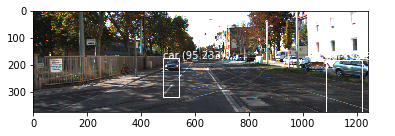

In [307]:
# draw what we found
draw_boxes(imagePath+photo_filename, v_boxes, v_labels, v_scores)